In [848]:
## Attaches burn probabilities to the ZTRAX data
## Uses lat and long provided 
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

In [849]:
## Get US Map for context and select Western United States
USMAP = gpd.read_file('/data/yoder/DensityProject/cb_2018_us_state_500k.shp')
West = ['WA', 'OR', 'CA', 'NV','AZ','NM', 'UT','CO','WY','ID','MT']

## Get map(s) of individual states if desired
CO_map = WestStates[WestStates['STUSPS']=='CO']
WestStates = USMAP[USMAP['STUSPS'].isin(West)]

##Convert Coordinate Reference System to US Natinoal Atlas Equal Area
WestStates = WestStates.to_crs("EPSG:2163")

In [850]:
scratchpath = '/scratch/user/joshua.olsen/20210428_153601/'
os.chdir(scratchpath)
## List all tables included in Zillow Variable names excel file
ZTransLayout = pd.read_excel('Layout.xlsx','ZTrans')
ZTransLayout['TableName'].unique()
ZAsmtLayout = pd.read_excel('Layout.xlsx','ZAsmt')

## Create dataframes from each table name in the Zillow table dictionary
    ## Strip 'ut' from column names
T = {}
for name,group in ZTransLayout.groupby('TableName'):
    T[str(name)[2:]] = group
A = {}
for name, group in ZAsmtLayout.groupby('TableName'):
    A[str(name)[2:]] = group
    
    
## Dictionary of Western 11 states using Zillows numbering: 
states = {'AZ':'04',
          'CA':'06',
          'CO':'08',
          'ID':'16',
          'MT':'30',
          'NV':'32',
          'NM':'35',
          'OR':'41',
          'UT':'49',
          'WA':'53',
          'WY':'56'}

In [851]:
#Change this value to the state and table you care about
# State to use
state = states['CO']
#Transaction tables to use
Ttables = ['Main', 'PropertyInfo']
# Assessment tables to use
Atables = ['Main','Garage', 'Building']

In [852]:
## Fields to use from transaction tables
Tfields = {'Main': ['TransId','State','County','DocumentDate','SignatureDate','RecordingDate','FIPS','DataClassStndCode',
                    'DocumentTypeStndCode','IntraFamilyTransferFlag','LoanTypeStndCode','PropertyUseStndCode','SalesPriceAmount', 'LoanAmount'],
            'PropertyInfo':['TransId','ImportParcelID','AssessorParcelNumber','PropertyFullStreetAddress','PropertyCity',
                            'PropertyState','PropertyAddressLatitude','PropertyAddressLongitude']}
# Fields to use from Assessment tables
Afields = {'Main': ['RowID','ImportParcelID','LotSizeSquareFeet'],
          'Garage':['RowID','GarageStndCode','GarageAreaSqFt'],
          'Building' :['RowID','YearBuilt','YearRemodeled','NoOfStories','TotalRooms','TotalBedrooms','TotalKitchens',
                       'FullBath','ThreeQuarterBath','HalfBath','QuarterBath','TotalActualBathCount',
                      'RoofCoverStndCode','HeatingTypeorSystemStndCode','FireplaceFlag','FireplaceNumber']}

In [853]:
%%time
## Load Ztrans data into dictionary of table entries that will be merged
dfs = {}
keys = Ttables
for i in keys:
    # Populate dictionary with desired tables for the given state
    dfs[i] = pd.read_csv(f'{state}/ZTrans\{i}.txt',sep = '|', header=None,names=T[i]['FieldName'].tolist(), encoding='latin1',usecols=Tfields[i]) 

<decorator-gen-54>:2: DtypeWarning: Columns (17,18,30) have mixed types.Specify dtype option on import or set low_memory=False.
<decorator-gen-54>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 2s, sys: 3.21 s, total: 1min 5s
Wall time: 1min 5s


In [854]:
%%time
## Load Assessor data

dfA = {}
keys = Atables
for j in keys:
    dfA[j] = pd.read_csv(f'{state}/ZAsmt\{j}.txt',sep='|', header=None,names=A[j]['FieldName'].tolist(),encoding='latin1',usecols=Afields[j])

<decorator-gen-54>:2: DtypeWarning: Columns (29,31,35) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 13.8 s, sys: 689 ms, total: 14.5 s
Wall time: 14.5 s


In [855]:
## Merge Trans tables and Asmt tables
from functools import reduce
Trans = reduce(lambda left,right: pd.merge(left,right,on='TransId',how='left'),dfs.values())
Asmt = reduce(lambda left, right:pd.merge(left,right,on='RowID',how='left'),dfA.values())
df = pd.merge(Trans,Asmt,on='ImportParcelID',how='left')

In [856]:
## Select only valid transactions
UnwantedLoanCodes =  ['AC','CT','CM','CS','CC','CL','DP','FO','FE','HE','LC','EB','EX','MD','NA','NP','FA','RE','RM','SM','SE','TR']
WantedLoanCodes =  ['AS','BL','CE','FM','PM','RD','SL']
DocumentTypeStndCodeDrop= ['CRDE','JTDE','QCDE','RRDE','VLDE']
DocumentTypeStndCodeKeep= ['CPDE','IDDE','PRDE','WRDE']

df = df.loc[(df['SalesPriceAmount'] > 0) &
            (~df['LoanTypeStndCode'].isin(UnwantedLoanCodes)) &
            (pd.isnull(df['IntraFamilyTransferFlag'])) &
            (df['PropertyUseStndCode']=='SR') &
            (df['DocumentTypeStndCode'].isin(DocumentTypeStndCodeKeep)) & 
            (df['TotalBedrooms'] >=1)].copy()

In [857]:
## Make geodataframe

CO = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.PropertyAddressLongitude, df.PropertyAddressLatitude))

In [861]:
CO_proj = CO.copy()
CO_proj.crs="epsg:4326"
CO_proj=CO_proj.to_crs("EPSG:2163")
CO_proj.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [864]:
import rasterio
from rasterstats import zonal_stats, point_query
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [865]:
dst_crs ="EPSG:2163"

In [866]:
with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
                   reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [867]:
src = rasterio.open('/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

/home/joshua.olsen/.conda/envs/testenv/lib/python3.8/site-packages/matplotlib/image.py:490: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


<AxesSubplot:>

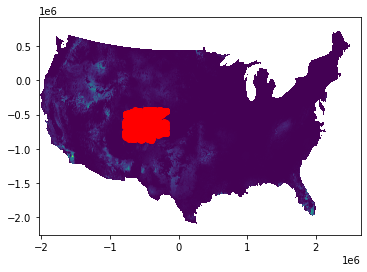

In [868]:
fig, ax = plt.subplots()
show(src,ax = ax)
CO_proj.plot(ax=ax, color ='red')

In [869]:
pts = CO_proj.copy()

In [870]:
CO_proj.shape

(1375077, 41)

In [871]:
## Select only valid geometry (note .isna() does not appear to catch point (nan,nan))
CO_pts = CO_proj[CO_proj['geometry'].is_valid]

In [872]:
CO_pts.shape

(1374190, 41)

In [873]:
# pts = CO_pts.head(100000).copy()
pts = CO_pts.copy()

In [874]:
%%time
pts['BP'] = point_query(pts, '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif')

CPU times: user 47min 4s, sys: 2min 44s, total: 49min 49s
Wall time: 50min 10s


In [875]:
%%time
## Add burn probability out to 1600 meters
pts['point_geometry'] = pts['geometry'].copy()
pts['geometry'] = pts.buffer(1600)
buff = pd.DataFrame(zonal_stats(pts, 
                             '/data/yoder/Spread_risk/Spread_risk_raster/BP_2016raster_2163.tif',
                            stats=['max','mean']))
buff.columns = [f'BP1600_'+str(col) for col in buff.columns]

buff.reset_index(drop=True,inplace=True)
pts.reset_index(drop=True,inplace=True)
pts = pd.concat([pts,buff],axis=1)
pts['geometry'] = pts['point_geometry'].copy()

CPU times: user 1h 6min 36s, sys: 4min 44s, total: 1h 11min 21s
Wall time: 1h 11min 29s


In [876]:
BurnCols = ['BP','BP1600_max','BP1600_mean']

In [877]:
pts[BurnCols].corr()

,BP,BP1600_max,BP1600_mean
BP,1.000000,0.797568,0.946865
BP1600_max,0.797568,1.000000,0.905899
BP1600_mean,0.946865,0.905899,1.000000


In [878]:
pts[BurnCols].describe()

,BP,BP1600_max,BP1600_mean
count,1.374190e+06,1.374190e+06,1.374190e+06
mean,3.147918e-04,1.065491e-03,4.097131e-04
std,1.046664e-03,1.532276e-03,1.050219e-03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000000e-04,1.043478e-05
50%,0.000000e+00,4.500000e-04,3.849558e-05
75%,4.873609e-05,1.299000e-03,2.660727e-04
max,1.141770e-02,1.188100e-02,1.009293e-02


In [880]:
#WA
pts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1374190 entries, 0 to 1374189
Data columns (total 45 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   TransId                      1374190 non-null  int64   
 1   FIPS                         1374190 non-null  int64   
 2   State                        1374190 non-null  object  
 3   County                       1374190 non-null  object  
 4   DataClassStndCode            1374190 non-null  object  
 5   RecordingDate                1374190 non-null  object  
 6   DocumentTypeStndCode         1374190 non-null  object  
 7   DocumentDate                 1368840 non-null  object  
 8   SignatureDate                0 non-null        object  
 9   SalesPriceAmount             1374190 non-null  float64 
 10  IntraFamilyTransferFlag      0 non-null        object  
 11  PropertyUseStndCode          1374190 non-null  object  
 12  LoanAmount          

<AxesSubplot:>

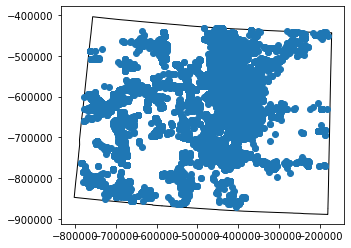

In [881]:
basemap = CO_map.plot(edgecolor='black',color='white')
pts.plot(ax= basemap)

In [883]:
pts.describe()

,TransId,FIPS,SalesPriceAmount,LoanAmount,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,LotSizeSquareFeet,GarageAreaSqFt,YearBuilt,...,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,FireplaceNumber,BP,BP1600_max,BP1600_mean
count,1.374190e+06,1.374190e+06,1.374190e+06,1.374115e+06,1.374190e+06,1.374190e+06,1.374190e+06,1.346898e+06,627766.000000,1.374141e+06,...,1402.000000,1.160653e+06,1406.0,1.162059e+06,1406.0,213534.000000,653243.000000,1.374190e+06,1.374190e+06,1.374190e+06
mean,1.400649e+08,8.041966e+03,2.455396e+05,1.934734e+05,3.958642e+01,-1.050404e+02,2.404495e+07,5.118194e+05,655.008008,1.971459e+03,...,1.052782,2.172345e+00,0.0,2.781098e-01,0.0,2.505389,1.284471,3.147918e-04,1.065491e-03,4.097131e-04
std,1.004161e+08,3.072776e+01,3.561942e+05,1.586173e+06,5.372693e-01,6.173692e-01,1.361857e+07,1.190906e+07,941.197417,2.633519e+01,...,0.226846,9.050653e-01,0.0,5.710391e-01,0.0,0.775084,0.538610,1.046664e-03,1.532276e-03,1.050219e-03
min,9.792263e+07,8.001000e+03,1.000000e+02,0.000000e+00,3.702700e+01,-1.090474e+02,2.153843e+07,1.000000e+00,1.000000,1.829000e+03,...,1.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.009878e+08,8.015000e+03,1.429900e+05,1.170000e+05,3.910009e+01,-1.050871e+02,2.212832e+07,6.250000e+03,340.000000,1.958000e+03,...,1.000000,2.000000e+00,0.0,0.000000e+00,0.0,1.750000,1.000000,0.000000e+00,2.000000e-04,1.043478e-05
50%,1.033800e+08,8.041000e+03,1.950000e+05,1.643500e+05,3.969266e+01,-1.049575e+02,2.268973e+07,7.841000e+03,450.000000,1.977000e+03,...,1.000000,2.000000e+00,0.0,0.000000e+00,0.0,2.500000,1.000000,0.000000e+00,4.500000e-04,3.849558e-05
75%,1.060529e+08,8.059000e+03,2.850000e+05,2.319035e+05,3.985659e+01,-1.047901e+02,2.312943e+07,1.089000e+04,576.000000,1.993000e+03,...,1.000000,3.000000e+00,0.0,0.000000e+00,0.0,3.250000,2.000000,4.873609e-05,1.299000e-03,2.660727e-04
max,4.495555e+08,8.123000e+03,1.000600e+08,9.745816e+08,4.099599e+01,-1.021245e+02,1.646407e+08,6.791875e+08,41791.000000,2.017000e+03,...,3.000000,2.000000e+01,0.0,8.000000e+00,0.0,9.500000,9.000000,1.141770e-02,1.188100e-02,1.009293e-02


In [989]:
## Create a copy of everything to merge with fires
## For Colorado base memory usage is 471mb with 1,374,190 rows
ST_points = pts.copy()

In [991]:
ST_points.info(())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1374190 entries, 0 to 1374189
Data columns (total 45 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   TransId                      1374190 non-null  int64   
 1   FIPS                         1374190 non-null  int64   
 2   State                        1374190 non-null  object  
 3   County                       1374190 non-null  object  
 4   DataClassStndCode            1374190 non-null  object  
 5   RecordingDate                1374190 non-null  object  
 6   DocumentTypeStndCode         1374190 non-null  object  
 7   DocumentDate                 1368840 non-null  object  
 8   SignatureDate                0 non-null        object  
 9   SalesPriceAmount             1374190 non-null  float64 
 10  IntraFamilyTransferFlag      0 non-null        object  
 11  PropertyUseStndCode          1374190 non-null  object  
 12  LoanAmount          

In [992]:
## Add fire perimeter data
import geopandas as gpd
Fireperims = gpd.read_file('/data/yoder/DensityProject/mtbs_perimeter_data/mtbs_perims_DD.shp')
Fireperims = Fireperims.to_crs("EPSG:2163")

In [993]:
CO_map = CO_map[['STUSPS', 'geometry']]

In [994]:
Buffed_state = CO_map.copy()

In [995]:
Buffed_state['geometry'] = Buffed_state.buffer(100000)

In [996]:
ST_fires = gpd.sjoin(Fireperims, Buffed_state, op='within')
ST_fires = ST_fires.drop(['index_right'], axis=1)
ST_fires['Buffed_geometry100km'] = ST_fires.buffer(100000)
ST_fires['MTBS_geometry'] = ST_fires['geometry'].copy()

In [997]:
ST_fires['geometry'] = ST_fires['Buffed_geometry100km'].copy()

<AxesSubplot:>

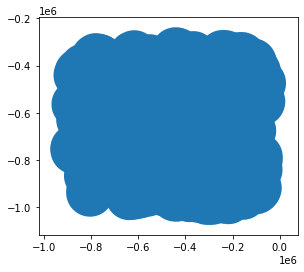

In [998]:
ST_fires.plot()

In [953]:
ST_samp = pts.sample(n=10000)

<AxesSubplot:>

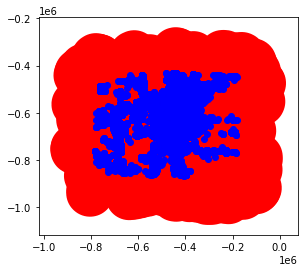

In [999]:
basemap = CO_map.plot(edgecolor='black',color='white')
ST_fires.plot(ax=basemap, color='red')
ST_points.plot(ax= basemap, color='blue')

In [1000]:
%%time
ST_Samp_with_Fires = gpd.sjoin(ST_points, ST_fires, how='left')

CPU times: user 12min 36s, sys: 2min 11s, total: 14min 47s
Wall time: 14min 49s


In [978]:
ST_Samp_with_Fires.columns

Index(['TransId', 'FIPS', 'State', 'County', 'DataClassStndCode',
       'RecordingDate', 'DocumentTypeStndCode', 'DocumentDate',
       'SignatureDate', 'SalesPriceAmount', 'IntraFamilyTransferFlag',
       'PropertyUseStndCode', 'LoanAmount', 'LoanTypeStndCode',
       'AssessorParcelNumber', 'PropertyFullStreetAddress', 'PropertyCity',
       'PropertyState', 'PropertyAddressLatitude', 'PropertyAddressLongitude',
       'ImportParcelID', 'RowID', 'LotSizeSquareFeet', 'GarageStndCode',
       'GarageAreaSqFt', 'YearBuilt', 'YearRemodeled', 'NoOfStories',
       'TotalRooms', 'TotalBedrooms', 'TotalKitchens', 'FullBath',
       'ThreeQuarterBath', 'HalfBath', 'QuarterBath', 'TotalActualBathCount',
       'RoofCoverStndCode', 'HeatingTypeorSystemStndCode', 'FireplaceFlag',
       'FireplaceNumber', 'geometry', 'BP', 'point_geometry', 'BP1600_max',
       'BP1600_mean', 'index_right', 'Fire_ID', 'Fire_Name', 'Year',
       'StartMonth', 'StartDay', 'Fire_Type', 'Acres', 'STUSPS',
      

<AxesSubplot:>

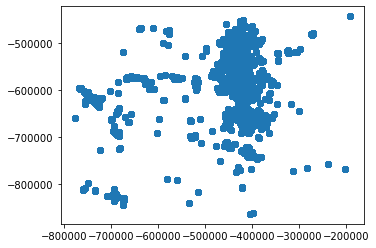

In [979]:
ST_Samp_with_Fires.plot()

In [980]:
pd.options.display.max_columns = None

In [1001]:
ST_Samp_with_Fires.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 41654318 entries, 0 to 1374189
Data columns (total 56 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   TransId                      int64   
 1   FIPS                         int64   
 2   State                        object  
 3   County                       object  
 4   DataClassStndCode            object  
 5   RecordingDate                object  
 6   DocumentTypeStndCode         object  
 7   DocumentDate                 object  
 8   SignatureDate                object  
 9   SalesPriceAmount             float64 
 10  IntraFamilyTransferFlag      object  
 11  PropertyUseStndCode          object  
 12  LoanAmount                   float64 
 13  LoanTypeStndCode             object  
 14  AssessorParcelNumber         object  
 15  PropertyFullStreetAddress    object  
 16  PropertyCity                 object  
 17  PropertyState                object  
 18  PropertyAddre

In [1002]:
ST_Samp_with_Fires.head()

,TransId,FIPS,State,County,DataClassStndCode,RecordingDate,DocumentTypeStndCode,DocumentDate,SignatureDate,SalesPriceAmount,IntraFamilyTransferFlag,PropertyUseStndCode,LoanAmount,LoanTypeStndCode,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyAddressLatitude,PropertyAddressLongitude,ImportParcelID,RowID,LotSizeSquareFeet,GarageStndCode,GarageAreaSqFt,YearBuilt,YearRemodeled,NoOfStories,TotalRooms,TotalBedrooms,TotalKitchens,FullBath,ThreeQuarterBath,HalfBath,QuarterBath,TotalActualBathCount,RoofCoverStndCode,HeatingTypeorSystemStndCode,FireplaceFlag,FireplaceNumber,geometry,BP,point_geometry,BP1600_max,BP1600_mean,index_right,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,STUSPS,Buffed_geometry100km,MTBS_geometry
0,97922632,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,NaN,91000.0,NaN,SR,60000.0,NaN,1815-27-2-14-010,765 4TH ST,BENNETT,CO,39.762606,-104.429201,21668273.0,D8F54216-820C-E811-80C3-3863BB430E3F,9583.0,AT,NaN,1979.0,NaN,NaN,6.0,3.0,NaN,3.0,NaN,0.0,NaN,NaN,CS,BB,NaN,1.0,POINT (-378761.206 -572048.397),0.000245,POINT (-378761.206 -572048.397),0.00065,0.000203,4533,CO3974110359220120625,LAST CHANCE,2012,6,25,Wildfire,17959.0,CO,"POLYGON ((-412752.181 -576122.035, -412771.922...","POLYGON ((-309176.231 -563870.221, -309173.610..."
0,97922632,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,NaN,91000.0,NaN,SR,60000.0,NaN,1815-27-2-14-010,765 4TH ST,BENNETT,CO,39.762606,-104.429201,21668273.0,D8F54216-820C-E811-80C3-3863BB430E3F,9583.0,AT,NaN,1979.0,NaN,NaN,6.0,3.0,NaN,3.0,NaN,0.0,NaN,NaN,CS,BB,NaN,1.0,POINT (-378761.206 -572048.397),0.000245,POINT (-378761.206 -572048.397),0.00065,0.000203,4567,CO4015910342120020601,UNNAMED,2002,6,1,Wildfire,8688.0,CO,"POLYGON ((-300552.448 -637901.905, -302088.984...","MULTIPOLYGON (((-294387.843 -532386.594, -2943..."
0,97922632,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,NaN,91000.0,NaN,SR,60000.0,NaN,1815-27-2-14-010,765 4TH ST,BENNETT,CO,39.762606,-104.429201,21668273.0,D8F54216-820C-E811-80C3-3863BB430E3F,9583.0,AT,NaN,1979.0,NaN,NaN,6.0,3.0,NaN,3.0,NaN,0.0,NaN,NaN,CS,BB,NaN,1.0,POINT (-378761.206 -572048.397),0.000245,POINT (-378761.206 -572048.397),0.00065,0.000203,4496,CO3888410493320120623,WALDO CANYON,2012,6,23,Wildfire,20112.0,CO,"POLYGON ((-326819.795 -630612.853, -326146.782...","POLYGON ((-431574.642 -660217.246, -431549.021..."
0,97922632,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,NaN,91000.0,NaN,SR,60000.0,NaN,1815-27-2-14-010,765 4TH ST,BENNETT,CO,39.762606,-104.429201,21668273.0,D8F54216-820C-E811-80C3-3863BB430E3F,9583.0,AT,NaN,1979.0,NaN,NaN,6.0,3.0,NaN,3.0,NaN,0.0,NaN,NaN,CS,BB,NaN,1.0,POINT (-378761.206 -572048.397),0.000245,POINT (-378761.206 -572048.397),0.00065,0.000203,4505,CO3901210474920130611,BLACK FOREST,2013,6,11,Wildfire,11886.0,CO,"POLYGON ((-298750.000 -658279.199, -298742.975...","MULTIPOLYGON (((-399271.265 -648634.207, -3992..."
0,97922632,8001,CO,ADAMS,H,1993-09-01,WRDE,NaN,NaN,91000.0,NaN,SR,60000.0,NaN,1815-27-2-14-010,765 4TH ST,BENNETT,CO,39.762606,-104.429201,21668273.0,D8F54216-820C-E811-80C3-3863BB430E3F,9583.0,AT,NaN,1979.0,NaN,NaN,6.0,3.0,NaN,3.0,NaN,0.0,NaN,NaN,CS,BB,NaN,1.0,POINT (-378761.206 -572048.397),0.000245,POINT (-378761.206 -572048.397),0.00065,0.000203,4509,CO3922010528720020608,HAYMAN,2002,6,8,Wildfire,129417.0,CO,"POLYGON ((-550978.417 -700188.208, -551141.504...","MULTIPOLYGON (((-469137.201 -634277.188, -4690..."


In [1004]:
def get_distance(row):
    distance = row.geometry.distance(row.MTBS_geometry)
    return distance

In [1005]:
%%time
ST_Samp_with_Fires['Distance'] = ST_Samp_with_Fires.apply(lambda row: get_distance(row),axis=1)

CPU times: user 46min 16s, sys: 2min 21s, total: 48min 38s
Wall time: 48min 41s


In [1008]:
ST_Samp_with_Fires['Distance'].describe()

count    4.165432e+07
mean     5.771893e+04
std      2.474532e+04
min      0.000000e+00
25%      3.853344e+04
50%      5.665875e+04
75%      7.880748e+04
max      9.999962e+04
Name: Distance, dtype: float64

In [1009]:
ST_Samp_with_Fires.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 41654318 entries, 0 to 1374189
Data columns (total 57 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   TransId                      int64   
 1   FIPS                         int64   
 2   State                        object  
 3   County                       object  
 4   DataClassStndCode            object  
 5   RecordingDate                object  
 6   DocumentTypeStndCode         object  
 7   DocumentDate                 object  
 8   SignatureDate                object  
 9   SalesPriceAmount             float64 
 10  IntraFamilyTransferFlag      object  
 11  PropertyUseStndCode          object  
 12  LoanAmount                   float64 
 13  LoanTypeStndCode             object  
 14  AssessorParcelNumber         object  
 15  PropertyFullStreetAddress    object  
 16  PropertyCity                 object  
 17  PropertyState                object  
 18  PropertyAddre